In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tscluster.opttscluster import OptTSCluster
from tscluster.preprocessing.utils import load_data

import warnings
warnings.filterwarnings('ignore')

import piccard as pc
import piccard2 as pc2

# unused
import networkx as nx
import re

In [15]:
households_data_2021 = gpd.read_file("data_testing/households_data_2021.geojson")
households_data_2016 = gpd.read_file("data_testing/households_data_2016.geojson")
households_data_2011 = gpd.read_file("data_testing/households_data_2011.geojson")
households_data_2006 = gpd.read_file("data_testing/households_data_2006.geojson")

households_data_2021.rename(columns={'v_CA21_434: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA21_435: Single-detached house': 'single_detached_house',
                                     'v_CA21_440: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2016.rename(columns={'v_CA16_408: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA16_409: Single-detached house': 'single_detached_house',
                                     'v_CA16_410: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2011.rename(columns={'v_CA11F_199: Total number of occupied private dwellings by structural type of dwelling': 'occupied_private_dwellings',
                                     'v_CA11F_200: Single-detached house': 'single_detached_house',
                                     'v_CA11F_201: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)
households_data_2006.rename(columns={'v_CA06_119: Total number of occupied private dwellings by structural type of dwelling - data': 'occupied_private_dwellings',
                                     'v_CA06_120: Single-detached house': 'single_detached_house',
                                     'v_CA06_124: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)

In [18]:
census_dfs = [households_data_2006, households_data_2011, households_data_2016, households_data_2021]
years = ['2006', '2011', '2016', '2021']

network_table = pc.create_network_table(census_dfs, years, 'GeoUID')
network_table

,geouid_2006,geouid_2011,geouid_2016,geouid_2021,shape area_2006,quality flags_2006,type_2006,households_2006,pr_uid_2006,dwellings_2006,...,region name_2021,area (sq km)_2021,occupied_private_dwellings_2021,single_detached_house_2021,apt_five_or_more_2021,name_2021,dwellings 2016_2021,population 2016_2021,households 2016_2021,network_level_2021
0,2006_5350001.00,2011_5350001.00,2016_5350001.00,2021_5350001.00,6.62223,01000,CT,231,35,245,...,0001.00,6.8192,235.0,15.0,0.0,0001.00,274.0,595.0,247.0,4
1,2006_5350002.00,2011_5350002.00,2016_5350002.00,2021_5350002.00,3.26165,00010,CT,262,35,273,...,0002.00,3.3926,285.0,250.0,0.0,0002.00,279.0,620.0,270.0,4
2,2006_5350003.00,2011_5350003.00,2016_5350003.00,2021_5350003.00,0.93043,None,CT,1,35,1,...,0003.00,0.9455,265.0,0.0,265.0,0003.00,267.0,749.0,258.0,4
3,2006_5350004.00,2011_5350004.00,2016_5350004.00,2021_5350004.00,0.34390,02020,CT,3335,35,3614,...,0004.00,0.3404,3275.0,70.0,1790.0,0004.00,3609.0,6686.0,3455.0,4
4,2006_5350005.00,2011_5350005.00,2016_5350005.00,2021_5350005.00,0.37841,01010,CT,2413,35,2575,...,0005.00,0.3764,3720.0,40.0,2420.0,0005.00,3729.0,6424.0,3424.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,2006_5350378.22,2011_5350378.22,2016_5350378.22,2021_5350378.22,0.53116,00000,CT,862,35,880,...,0378.22,0.5321,870.0,800.0,0.0,0378.22,891.0,3454.0,877.0,4
583,2006_5350378.23,2011_5350378.23,2016_5350378.23,2021_5350378.23,1.53841,00001,CT,1282,35,1309,...,0378.23,1.5314,1280.0,635.0,325.0,0378.23,1334.0,4095.0,1302.0,4
584,2006_5350378.24,2011_5350378.24,2016_5350378.24,2021_5350378.24,2.52091,00011,CT,1861,35,1947,...,0378.24,2.5129,2125.0,450.0,820.0,0378.24,2218.0,6109.0,2147.0,4
585,2006_5350802.01,2011_5350802.01,2016_5350802.01,2021_5350802.01,2.22576,00000,CT,1242,35,1269,...,0802.01,2.1742,1305.0,810.0,0.0,0802.01,1290.0,3829.0,1267.0,4


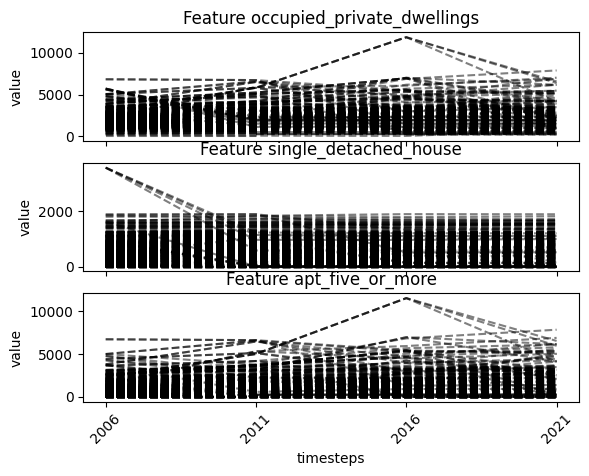

In [17]:
from tscluster.tsplot import tsplot

arr, label_dict = pc2.clustering_prep(network_table, 'name', [
    'occupied_private_dwellings_2006', 'single_detached_house_2006', 'apt_five_or_more_2006',
    'occupied_private_dwellings_2011', 'single_detached_house_2011', 'apt_five_or_more_2011',
    'occupied_private_dwellings_2016', 'single_detached_house_2016', 'apt_five_or_more_2016', 
    'occupied_private_dwellings_2021', 'single_detached_house_2021', 'apt_five_or_more_2021'])

fig, ax = tsplot.plot(X=arr, label_dict=label_dict)

In [2]:
# we will use the elbow method to determine the optimal number of clusters
from sympy import false
import setuptools.dist
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans(random_state=4,n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10),timings=False, ax=plt.gca())
visualizer.fit(arr)       # Fit data to visualizer
plt.title('Elbow Method for Optimal k using Sum of Square Error')
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.show()

ModuleNotFoundError: No module named 'setuptools'

In [ ]:
G = pc.create_network(census_dfs, years, 'GeoUID', 0.05)
opt_ts = pc2.cluster(network_table, G, 'GeoUID', 4, arr=arr, label_dict=label_dict)

Warm starting...
Done with warm start after 0.05secs

Obj val: [3925.]

Total time is 289.87secs



In [29]:
network_table['cluster_assignment_2011'].head(20)

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     0
8     3
9     3
10    1
11    0
12    0
13    3
14    3
15    3
16    3
17    3
18    3
19    3
Name: cluster_assignment_2011, dtype: int64

In [ ]:
list(G.nodes(data=True))[:3]

[('2006_5350001.00',
  {'Shape Area': 6.62223,
   'Quality Flags': '01000',
   'Type': 'CT',
   'Households': 231,
   'PR_UID': '35',
   'Dwellings': 245,
   'Population': 571,
   'CMA_UID': '35535',
   'CSD_UID': '3520005',
   'CD_UID': '3520',
   'Region Name': 'Toronto',
   'Area (sq km)': 6.62223,
   'occupied_private_dwellings': 230.0,
   'single_detached_house': 10.0,
   'apt_five_or_more': 0.0,
   'NHS Non-Return Rate': nan,
   'Adjusted Population (previous Census)': nan,
   'name': nan,
   'Dwellings 2016': nan,
   'Population 2016': nan,
   'Households 2016': nan,
   'network_level': 1,
   'cluster_assignment': 0}),
 ('2011_5350001.00',
  {'Shape Area': 6.62211,
   'Quality Flags': '00000',
   'Type': 'CT',
   'Households': 264,
   'PR_UID': '35',
   'Dwellings': 283,
   'Population': 604,
   'CMA_UID': '35535',
   'CSD_UID': '3520005',
   'CD_UID': '3520',
   'Region Name': 'Toronto',
   'Area (sq km)': 6.62211,
   'occupied_private_dwellings': 265.0,
   'single_detached_hou